<h1>Fraud and Anomaly Detection</h1>

In [14]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, array, random, argsort
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

<h2>Step 1: Data Preparation</h2>

In [3]:
# Load the file containing the financial transactions
df = pd.read_csv('FI_Transactions.csv')

In [15]:
# Show the first five rows
df.head()

,BUKRS,BELNR,GJAHR,MONAT,USNAM,WAERS,BSCHL,KOART,DMBTR,HKONT,LIFNR,Fraudulent
0,1000,20000001,2018,1,MSEK,CAD,25,K,200,100000,11223344,-1
1,1000,20000002,2018,2,MSEK,CAD,25,K,200,100000,11223344,1
2,1000,20000003,2018,3,MSEK,CAD,25,K,200,100000,11223344,1
3,1000,20000004,2018,4,MSEK,CAD,25,K,200,100000,11223344,1
4,1000,20000005,2018,5,MSEK,CAD,25,K,200,100000,11223344,1


<h2>Step 2: Exploratory Data Analysis</h2>

In [16]:
# Check dimensions of the data frame (imported table). There are 50 rows and 12 columns here.
df.shape

(50, 12)

In [17]:
# Summary statistics for all columns
df.describe(include='all')

,BUKRS,BELNR,GJAHR,MONAT,USNAM,WAERS,BSCHL,KOART,DMBTR,HKONT,LIFNR,Fraudulent
count,50.000000,5.000000e+01,50.000000,50.000000,50,50,50.0,50,50.000000,50.000000,5.000000e+01,50.000000
unique,NaN,NaN,NaN,NaN,4,2,NaN,1,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,MSEK,CAD,NaN,K,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,21,40,NaN,50,NaN,NaN,NaN,NaN
mean,1340.000000,2.000003e+07,2019.640000,6.340000,NaN,NaN,25.0,NaN,6344.000000,126000.000000,1.122335e+07,0.800000
std,688.387646,1.457738e+01,1.102132,3.230025,NaN,NaN,0.0,NaN,23904.189369,44308.749769,6.456258e+00,0.606092
min,1000.000000,2.000000e+07,2018.000000,1.000000,NaN,NaN,25.0,NaN,100.000000,100000.000000,1.122334e+07,-1.000000
25%,1000.000000,2.000001e+07,2019.000000,4.000000,NaN,NaN,25.0,NaN,200.000000,100000.000000,1.122334e+07,1.000000
50%,1000.000000,2.000003e+07,2020.000000,6.500000,NaN,NaN,25.0,NaN,200.000000,100000.000000,1.122334e+07,1.000000
75%,2000.000000,2.000004e+07,2021.000000,9.000000,NaN,NaN,25.0,NaN,800.000000,175000.000000,1.122335e+07,1.000000


In [18]:
# Display data types of all columns. All are integers except for user name, currency code and account type
df.dtypes

BUKRS          int64
BELNR          int64
GJAHR          int64
MONAT          int64
USNAM         object
WAERS         object
BSCHL          int64
KOART         object
DMBTR          int64
HKONT          int64
LIFNR          int64
Fraudulent     int64
dtype: object

In [27]:
# Show all the unique values for the user, currency and account
df['USNAM'].unique()

array(['MSEK', 'KMES', 'PKIM', 'LUKE'], dtype=object)

In [28]:
df['WAERS'].unique()

array(['CAD', 'USD'], dtype=object)

In [29]:
df['KOART'].unique()

array(['K'], dtype=object)

Text(0, 0.5, 'Amount ($)')

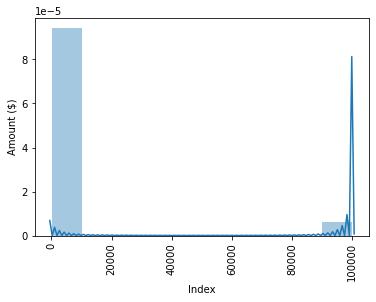

In [84]:
# Plot the Amount to see how the distribution looks like.
df_amounts = df[['DMBTR']]
df_amounts = pd.DataFrame(df_amounts)

x_ax = range(50)
sns.distplot(df_amounts['DMBTR'], bins=10)
plt.xticks(rotation = 90)
plt.xlabel('Index')
plt.ylabel('Amount ($)')

<h2>Step 3: Apply Inter Quartile Method</h2>

In [85]:
# Get the first and third quartile to calculate the inter quartile range. Then check if the amount falls 1.5 times below Q1 or above Q3. Mark these data points as outliers.
Q1 = df_amounts.quantile(0.25)
Q3 = df_amounts.quantile(0.75)

IQR = Q3 - Q1

df_final = df_amounts[(df_amounts[['DMBTR']]<(Q1-1.5*IQR)) | (df_amounts[['DMBTR']]>(Q3+1.5*IQR))]
df_final = df_final.rename(columns={'DMBTR': 'Flagged'})

In [86]:
df_final.head()

,Flagged
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [87]:
# To follow similiar logic to how Fraudulent was defined (check Chapter 21 for definition). 1 represents a normal data point (inliers) whereas -1 is the one we identify as outliers
df_final[df_final.notna()] = -1
df_final[df_final.isna()] = 1

In [88]:
df_final['Flagged'] = df_final['Flagged'].astype(int)

In [89]:
df_final.head()

,Flagged
0,1
1,1
2,1
3,1
4,1


In [90]:
# Print the evaluation metrics. Pay particular attention to f1-score for Fraud and Not Fraud labels.
ytrue = df['Fraudulent']
yhat = df_final['Flagged']
print(classification_report(ytrue, yhat, target_names=['Fraud', 'Not Fraud']))

              precision    recall  f1-score   support

       Fraud       0.67      0.40      0.50         5
   Not Fraud       0.94      0.98      0.96        45

    accuracy                           0.92        50
   macro avg       0.80      0.69      0.73        50
weighted avg       0.91      0.92      0.91        50



In [46]:
# Show the F1 score for the IQR method
method1_score = f1_score(ytrue, yhat, pos_label=-1)
method1_score
print('F1 Score for IQR: %.3f' % method1_score)

F1 Score for IQR: 0.500


<h2>Step 4: Perform Supervised Learning - Support Vector Machines</h2>

In [72]:
# Define the features to use (X) for the ML model and the target to predict (y)
X = df[['LIFNR']] 
# X = df[['DMBTR','BUKRS','LIFNR']] # Additional features can be added this way
y = df['Fraudulent']

# Split into train/test sets
trainX, testX, trainy, ytrue = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# Create a one class SVM Model
model = OneClassSVM(gamma='scale', nu=0.01)

# Fit on majority class
trainX = trainX[trainy==1]
model.fit(trainX)

# Detect outliers in the test set
yhat = model.predict(testX)

# Calculate the evaluation metrics
print(classification_report(ytrue, yhat, target_names=['Fraud', 'Not Fraud']))

              precision    recall  f1-score   support

       Fraud       0.67      0.67      0.67         3
   Not Fraud       0.95      0.95      0.95        22

    accuracy                           0.92        25
   macro avg       0.81      0.81      0.81        25
weighted avg       0.92      0.92      0.92        25



In [73]:
# Display the F1 score for the SVM method
method2_score = f1_score(ytrue, yhat, pos_label=-1)
print('F1 Score for SVM: %.3f' % method2_score)

F1 Score for SVM: 0.667


<h2>Step 5: Perform Unsupervised Learning - K-Means Clustering</h2>

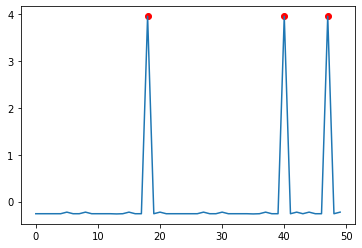

In [74]:
# Use the amount column and scale it for analysis
X = df[['DMBTR']]
# X = df[['DMBTR','BUKRS','LIFNR']] # Additional features can be added this way
X = pd.DataFrame(X)
X = scale(X)

# Train the K-Means model by fitting it with the data. This is a one cluster model because it is used to detect anomalies for the amount feature.
kmeans = KMeans(n_clusters = 1).fit(X)

# Get the center of the cluster
center = kmeans.cluster_centers_

# Calculate the euclidean distance of a given data point from the center of the cluster
distance = sqrt((X - center)**2)

# Sort the distance along with the index of the data points
order_index = argsort(distance, axis = 0)

# Get the three farthest points
indexes = order_index[-3:]
values = X[indexes]

# Plot the result. Here the red points indicate the suspected anomalies based on their distance from the other points.
x_ax = range(X.shape[0])
plt.plot(x_ax, X)
plt.scatter(indexes, values, color='r')
plt.show()

In [75]:
# Create a new data frame with the suspected fraud transactions and the actual fraud transactions
df_final = df[['Fraudulent']]
df_final = pd.DataFrame(df_final)
df_final['ytest'] = 1
df_final.head()

,Fraudulent,ytest
0,-1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [76]:
# Set the detected outliers as -1
for i in range(len(indexes)):
    df_final['ytest'][indexes[i]] = -1

In [77]:
# Print the evaluation metrics
ytrue = df_final['ytest']
yhat = df_final['Fraudulent']
print(classification_report(ytrue, yhat, target_names=['Fraud', 'Not Fraud']))

              precision    recall  f1-score   support

       Fraud       0.40      0.67      0.50         3
   Not Fraud       0.98      0.94      0.96        47

    accuracy                           0.92        50
   macro avg       0.69      0.80      0.73        50
weighted avg       0.94      0.92      0.93        50



In [80]:
# Calculate F1-score for K-Means
method3_score = f1_score(ytrue, yhat, pos_label=-1)
print('F1 Score for K-Means: %.3f' % method3_score)

F1 Score for K-Means: 0.500


In [81]:
# Show the final results
final_data = [['Inter-Quartile Range: ', round(method1_score,2)], ['Supervised Learning - One-class SVM: ', round(method2_score,2)], ['Unsupervised Learning - K-Means Outlier Detection', round(method3_score,2)]]
final_results = pd.DataFrame(final_data, columns = ['Method', 'F1-Score'])
final_results

,Method,F1-Score
0,Inter-Quartile Range:,0.50
1,Supervised Learning - One-class SVM:,0.67
2,Unsupervised Learning - K-Means Outlier Detection,0.50
